In [1]:
import pickle

import arviz as az
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn.objects as so


T_STEADY_STATE = 4  # years, Assumed time to CD4+ steady state.


def read_obs_hiv_cd4_timeseries():
    """Read the patient cd4 time series spreadsheet."""
    df = pd.read_csv("../data/pantaleo1995-figure1.csv")
    df = df.rename({"cd4_cells_per_mm3": "cd4"}, axis='columns')
    df.year += T_STEADY_STATE
    df["day"] = df.year * 365
    # Convert subject strings to float for PyMC's Distribution class that has a
    # convert_observed_data() function that assumes all data should be float.
    df["group"] = df["group"].str.extract(r"subject(\d+)")
    return df


# Sorting by time is necessary for merging columns later on.
DF_OBSERVED = read_obs_hiv_cd4_timeseries().sort_values("day")
# Collapse data into single representative sample.
DF_OBSERVED_1 = DF_OBSERVED[DF_OBSERVED["group"] == "1"]
OBSERVED = DF_OBSERVED_1.cd4.to_numpy()
# Only solve the ODE system at timepoints for which we have data.  T_VALS is in
# days because all the parameter units are in days.
T_VALS = DF_OBSERVED_1.day.to_numpy()
# Initial values.
Y0 = [1e3, 0, 0, 1e-3]


def hiv(y, t, s, r, T_max, mu_T, mu_b, mu_V, k_1, k_2, N):
    """Rates of change RHS (equations 5a-5d, page 87)."""
    return np.array([
        # T
        s - mu_T*y[0] + r*y[0]*(1 - (y[0] + y[1] + y[2])/T_max) -
        k_1*y[3]*y[0],
        # T_li
        k_1*y[3]*y[0] - mu_T*y[1] - k_2*y[1],
        # T_ai
        k_2*y[1] - mu_b*y[2],
        # V
        N*mu_b*y[2] - k_1*y[3]*y[0] - mu_V*y[3],
    ])


def simulate_hiv(rng, s, r, T_max, mu_T, mu_b, mu_V, k_1, k_2, N, size=None):
    return odeint(hiv, Y0, T_VALS, rtol=0.1, mxstep=100,
                  args=(s, r, T_max, mu_T, mu_b, mu_V, k_1, k_2, N))

In [2]:
with open("perelson1993-01_output-idata_hiv.pkl", "rb") as file_:
    idata_hiv = pickle.load(file_)

In [3]:
az.summary(idata_hiv)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
T_max,739.878,84.470,578.000,905.000,2.359,1.668,1411.0,854.0,1.01
N,932.458,244.158,500.000,1408.000,4.305,3.044,3184.0,1763.0,1.00
s,0.360,0.290,0.022,0.852,0.006,0.005,2881.0,3263.0,1.00
r,689.966,339.945,163.349,1280.465,6.776,4.950,2243.0,1129.0,1.00
mu_T,91.176,57.474,9.372,193.749,1.678,1.187,1285.0,1043.0,1.01
mu_b,18.339,12.991,1.672,42.694,0.308,0.222,1995.0,1210.0,1.01
mu_V,1.509,1.267,0.060,3.548,0.035,0.028,1913.0,1397.0,1.00
k_1,149990.703,142438.773,8871.111,348582.425,4470.993,4100.702,1730.0,1408.0,1.00
k_2,1022.530,840.355,36.416,2459.644,19.438,13.747,1809.0,1193.0,1.01


In [4]:
posterior = idata_hiv.posterior.stack(samples=('draw', 'chain'))
posterior

<xarray.Dataset>
Dimensions:  (samples: 16000)
Coordinates:
  * samples  (samples) object MultiIndex
  * draw     (samples) int64 0 0 0 0 0 0 0 ... 1999 1999 1999 1999 1999 1999
  * chain    (samples) int64 0 1 2 3 4 5 6 7 0 1 2 3 ... 4 5 6 7 0 1 2 3 4 5 6 7
Data variables:
    T_max    (samples) int64 680 853 685 721 664 695 ... 853 1005 774 799 667
    N        (samples) int64 1019 677 1041 916 652 ... 1031 1072 1466 1403 1052
    s        (samples) float64 0.4859 0.1421 0.2268 ... 0.2796 0.5352 0.1847
    r        (samples) float64 468.6 613.5 614.3 ... 368.5 1.083e+03 763.8
    mu_T     (samples) float64 36.9 149.8 37.88 82.71 ... 192.3 165.0 156.9 40.9
    mu_b     (samples) float64 24.54 19.56 25.25 3.824 ... 15.08 12.55 16.34
    mu_V     (samples) float64 2.068 1.121 1.353 2.687 ... 4.628 0.9525 2.414
    k_1      (samples) float64 5.449e+04 4.741e+05 ... 1.037e+05 3.55e+05
    k_2      (samples) float64 348.2 1.89e+03 946.7 ... 1.927e+03 395.3 770.9
Attributes:
    created_at:                 2023-06-20T21:08:17.551965
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

array([[<Axes: title={'center': 'T_max'}>, <Axes: title={'center': 'N'}>,
        <Axes: title={'center': 's'}>],
       [<Axes: title={'center': 'r'}>, <Axes: title={'center': 'mu_T'}>,
        <Axes: title={'center': 'mu_b'}>],
       [<Axes: title={'center': 'mu_V'}>,
        <Axes: title={'center': 'k_1'}>, <Axes: title={'center': 'k_2'}>]],
      dtype=object)

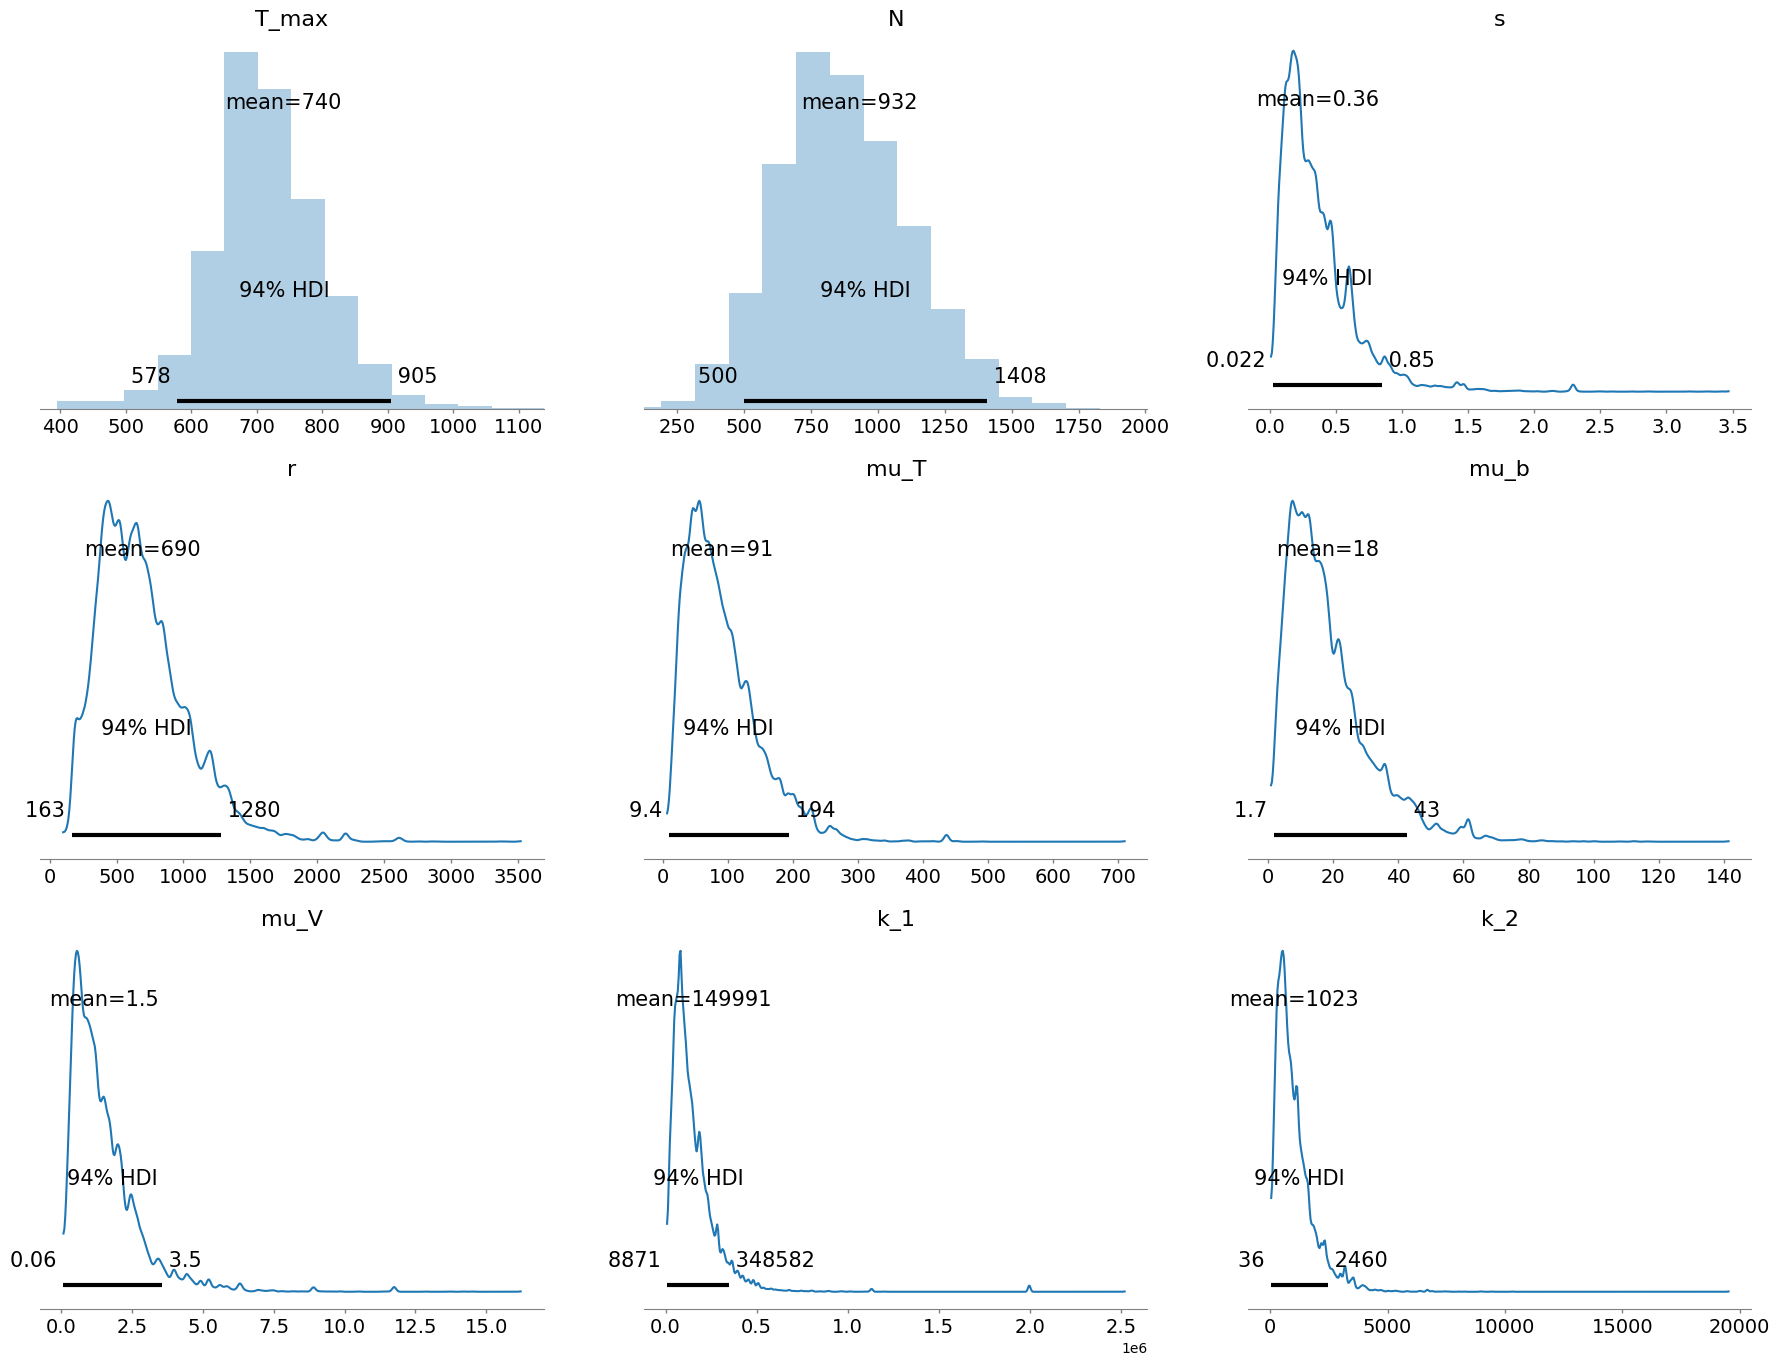

In [5]:
az.plot_posterior(idata_hiv)

array([[<Axes: ylabel='N'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='s'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='r'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_T'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_b'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='mu_V'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='k_1'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='T_max', ylabel='k_2'>, <Axes: xlabel='N'>,
        <Axes: xlabel='s'>, <Axes: xlabel='r'>, <Axes: xlabel='mu_T'>,
        <Axes: xlabel='mu_b'>, <Axes: xlabel='mu_V'>,
        <Axes: xlabel='k_1'>]], dtype=object)

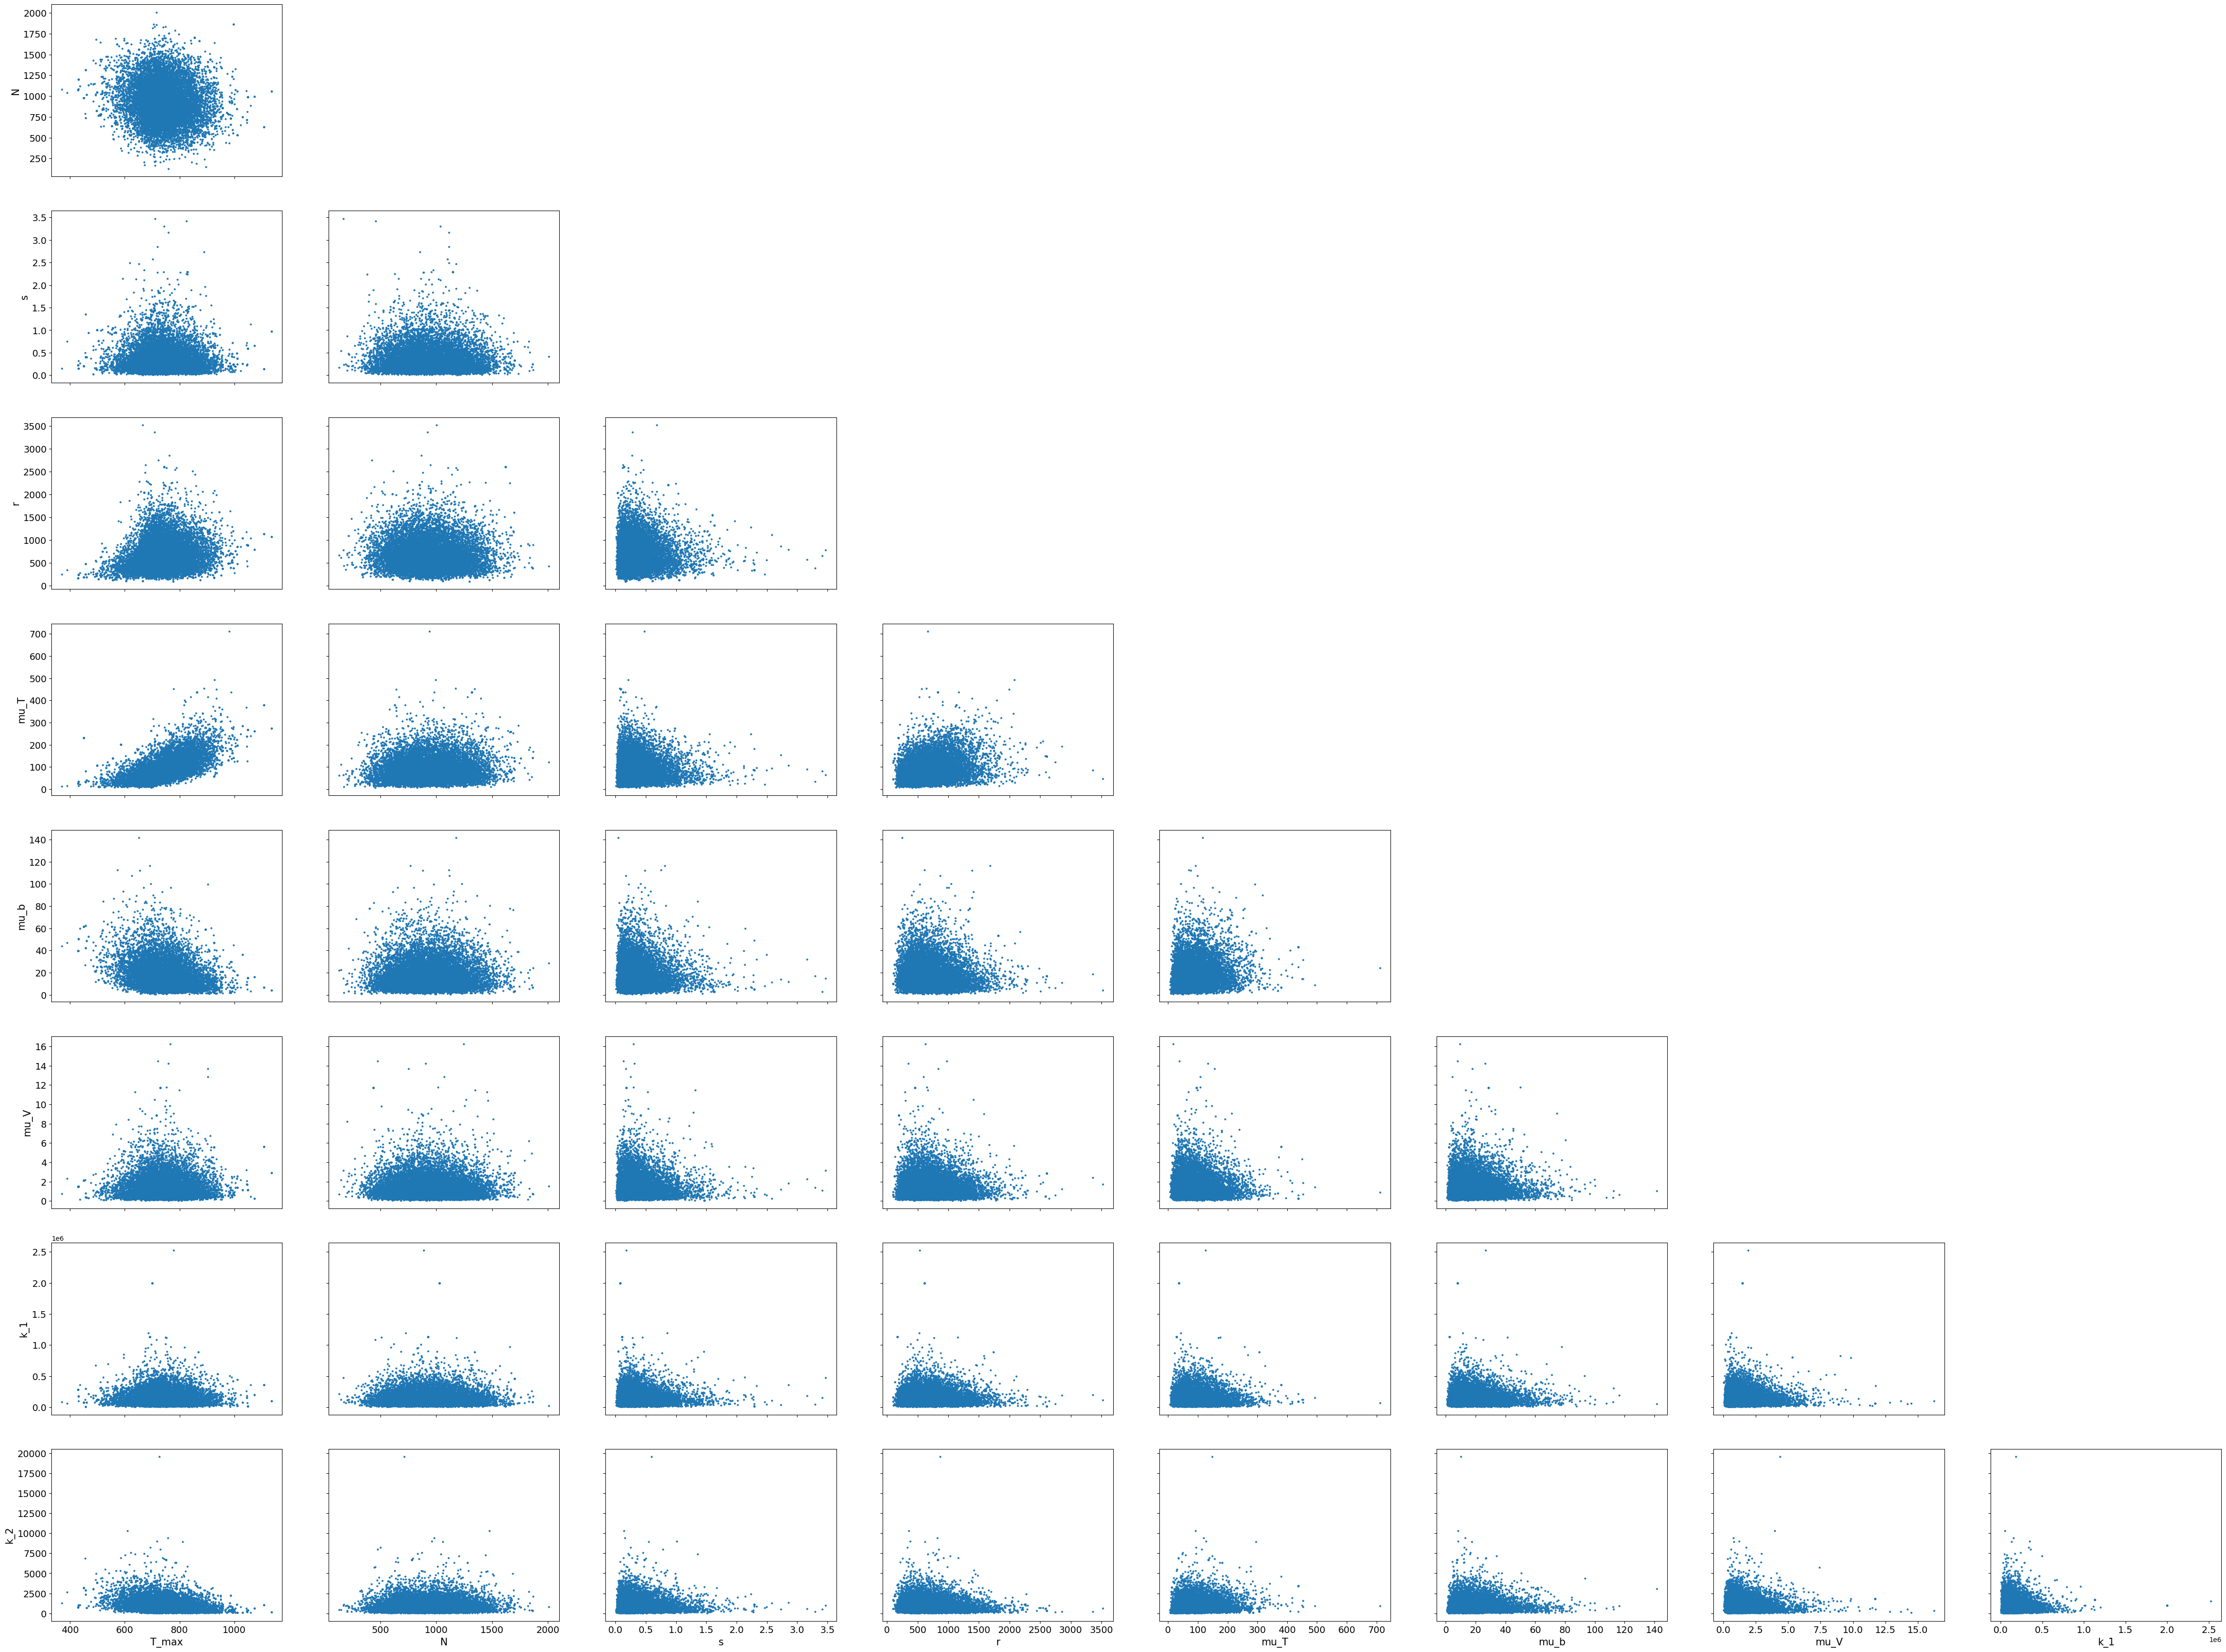

In [ ]:
az.plot_pair(idata_hiv)

In [7]:
obs_var = [key for key in idata_hiv.observed_data.variables.keys()][-1]
obs_cd4 = idata_hiv.observed_data[obs_var]
obs_cd4

<xarray.DataArray 'sim' (sim_dim_0: 18)>
array([ 540.,  660.,  820.,  660.,  780.,  980.,  620.,  940.,  940.,
        700.,  580.,  940.,  980., 1060., 1020.,  820.,  940.,  820.])
Coordinates:
  * sim_dim_0  (sim_dim_0) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17

In [8]:
params = [key for key in idata_hiv.posterior.keys()]
params

['T_max', 'N', 's', 'r', 'mu_T', 'mu_b', 'mu_V', 'k_1', 'k_2']

In [9]:
num_samples=1000
samples = az.extract(idata_hiv, num_samples=num_samples)
samples

<xarray.Dataset>
Dimensions:  (sample: 1000)
Coordinates:
  * sample   (sample) object MultiIndex
  * chain    (sample) int64 0 1 1 6 0 0 7 4 2 4 4 3 ... 5 5 1 1 0 1 4 3 4 1 3 5
  * draw     (sample) int64 1228 1656 1327 459 1618 ... 425 1146 395 1289 1827
Data variables:
    T_max    (sample) int64 781 899 802 757 561 709 ... 684 762 646 895 802 702
    N        (sample) int64 1169 1104 768 1119 816 ... 743 1146 681 1156 785
    s        (sample) float64 0.2538 0.3545 0.63 0.589 ... 0.0956 0.4504 0.7998
    r        (sample) float64 456.0 1e+03 627.5 ... 486.1 1.095e+03 1.016e+03
    mu_T     (sample) float64 74.32 259.0 109.3 69.74 ... 202.1 203.2 45.46
    mu_b     (sample) float64 9.929 12.36 29.33 11.34 ... 7.299 59.2 20.86 3.938
    mu_V     (sample) float64 1.043 1.811 1.557 0.647 ... 0.6623 0.1708 2.801
    k_1      (sample) float64 7.458e+04 1.027e+05 ... 7.514e+04 2.98e+05
    k_2      (sample) float64 487.0 1.283e+03 275.8 374.8 ... 883.2 886.8 252.3
Attributes:
    created_at:                 2023-06-20T21:08:17.551965
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.3.0

In [10]:
df = samples.to_dataframe()
df.drop(columns=df.columns[[-2, -1]], inplace=True)
df["cd4"] = df.apply(lambda x: np.sum(simulate_hiv(None, *x)[:, 0:3], axis=1), axis=1)
df = df.explode("cd4")
df["cd4"] = pd.to_numeric(df["cd4"])
df["day"] = np.tile(T_VALS, num_samples)
# seaborn's object interface can't use the intersection of 2 groups yet.
df["sample"] = df.groupby(["chain", "draw"]).ngroup()
# seaborn plotting runs extremely slowly if multi-indexing is active.
df = df.reset_index()
df

/Users/pnanda/Library/Python/3.11/lib/python/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


,chain,draw,T_max,N,s,r,mu_T,mu_b,mu_V,k_1,k_2,cd4,day,sample
0,0,1228,781,1169,0.253802,456.048348,74.318882,9.929167,1.042838,74580.134420,486.990800,1000.000000,1642.5,85
1,0,1228,781,1169,0.253802,456.048348,74.318882,9.929167,1.042838,74580.134420,486.990800,4.813154,1825.0,85
2,0,1228,781,1169,0.253802,456.048348,74.318882,9.929167,1.042838,74580.134420,486.990800,2830.522980,2007.5,85
3,0,1228,781,1169,0.253802,456.048348,74.318882,9.929167,1.042838,74580.134420,486.990800,3937.797647,2190.0,85
4,0,1228,781,1169,0.253802,456.048348,74.318882,9.929167,1.042838,74580.134420,486.990800,3733.525412,2372.5,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17995,5,1827,702,785,0.799826,1015.561674,45.461874,3.937933,2.801167,298006.455501,252.271238,1.486355,4015.0,754
17996,5,1827,702,785,0.799826,1015.561674,45.461874,3.937933,2.801167,298006.455501,252.271238,1.486355,4197.5,754
17997,5,1827,702,785,0.799826,1015.561674,45.461874,3.937933,2.801167,298006.455501,252.271238,1.486355,4380.0,754
17998,5,1827,702,785,0.799826,1015.561674,45.461874,3.937933,2.801167,298006.455501,252.271238,1.486355,4745.0,754


In [11]:
df.describe()

,chain,draw,T_max,N,s,r,mu_T,mu_b,mu_V,k_1,k_2,cd4,day,sample
count,18000.000000,18000.000000,18000.00000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,18000.000000,1.800000e+04,18000.000000,18000.000000,18000.000000,18000.000000
mean,3.459000,1005.755000,739.78900,943.525000,0.359502,686.624925,90.195995,17.772259,1.557085,1.557980e+05,987.419751,63.281390,3218.083333,499.500000
std,2.253575,584.786198,84.11631,243.014741,0.275414,326.105132,57.255565,12.573176,1.294549,1.475311e+05,795.354935,254.616970,979.292719,288.683009
min,0.000000,0.000000,450.00000,190.000000,0.014250,161.988919,9.979593,1.099544,0.059876,7.414868e+03,36.415932,0.135393,1642.500000,0.000000
25%,2.000000,499.750000,691.00000,771.000000,0.166986,441.512167,46.607090,8.759203,0.681488,6.846283e+04,436.933100,1.805033,2372.500000,249.750000
50%,4.000000,1014.500000,733.00000,918.000000,0.300746,632.298916,78.179960,14.654423,1.205959,1.166654e+05,769.342007,3.076053,3230.250000,499.500000
75%,5.000000,1522.000000,785.00000,1107.250000,0.473129,850.922754,119.253986,23.352413,2.014378,2.021845e+05,1282.132225,4.793775,4015.000000,749.250000
max,7.000000,1997.000000,1108.00000,1862.000000,2.291694,2609.143278,436.934821,78.647673,11.721954,1.995563e+06,6853.278630,3994.797647,4927.500000,999.000000


In [12]:
# TODO: Encapsulate observed data and row-bind it to the simulations for plotting.
df_data = pd.DataFrame({})

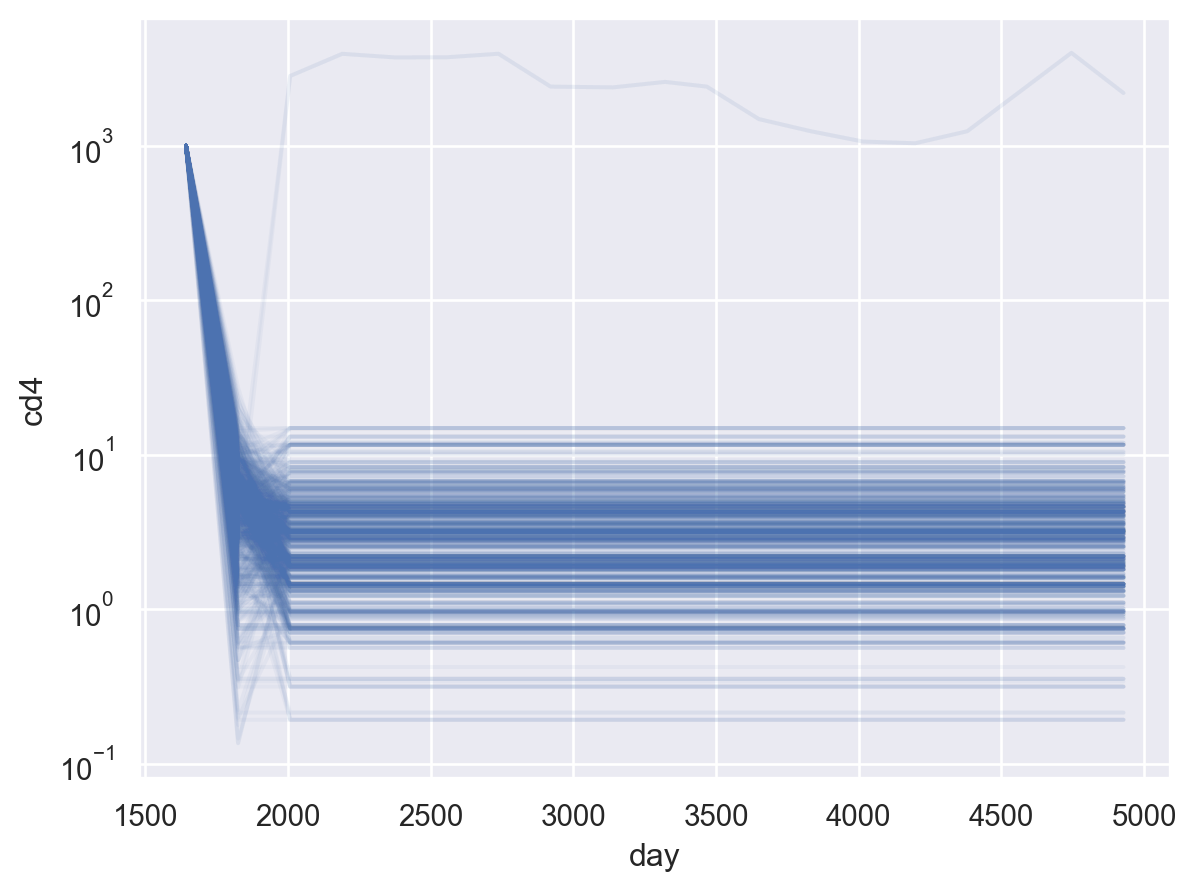

In [13]:
(
    so.Plot(df, x="day", y="cd4", group="sample")
    .add(so.Line(alpha = 0.05))
    .scale(y="log")
)